# **Evaluating B.C.'s Opioid Antagonist Treatment (OAT) Policies (2015-2018)**


# -- A statistical approach




# Context
An Opiiod Antagonist Treatment (OAT) policy, is when patients with opioid use disorder access specific drugs to stabilize their opioid use and avoid illicit drugs. My task is to evaluate two policy changes:

 

*   Policy for Drug B (Naloxone): Effective October 2015, patients no longer need special approval to have PharmaCare pay for drug B. They no longer need to try less effective drugs before 
*   Policy for Drug C (Slow-release Morphine): Effective June 2017, patients can access drug C as an alternative treatment, under certain circumstances. It is covered and they do not have to pay for it


  

# Response (Approach):


1.   Visual analysis, of patient uptake of said drugs, 'before and after' the policies 
2.   Regression analysis, for the above with t-statistics
3.   Compare against a Control (Drug A), where no policy had been applied 









# Loading and Transforming 
- Data file has three columns: date (by month) ; drug type (A.B,C); patient ID (unique)
- Aggregate (or group by) total number of patients by drug type and by month (i.e., take the sum of distinct patient IDs each month)
- Drop the seven missing values among the 268,000 data points

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
# Install and load packages
%%capture
%%R
install.packages(c('dplyr', 'magrittr','skimr','tidyr','janitor','ggplot2','readr','datetime','reshape2'))
x<-c('dplyr', 'magrittr','skimr','tidyr','janitor','ggplot2','readr','datetime','reshape2')
lapply(x, require, character.only = TRUE)

In [ ]:
# Read the csv data file, while making appropriate changes to data type, such as 'factors' and 'dates'
%%R
OAT <- read_csv("OAT.csv",  col_names = FALSE, 
                col_types = cols(X2 = col_factor(levels = c("A","B", "C")), X3 = col_date(format = "%Y-%m")))

In [ ]:
# Examine the three columns in the data: 
# X3 - date; X2 - drug type; X1 - patients ID 
%%R
head(OAT)

# A tibble: 6 × 3
     X1 X2    X3        
  <dbl> <fct> <date>    
1     1 B     2007-12-01
2     1 B     2008-08-01
3     1 B     2008-09-01
4     1 B     2008-10-01
5     1 B     2008-11-01
6     1 B     2008-12-01


.
*   The meta data shows the type of data: Date, Patient ID and Drug (both are factors)
*   Total number of records is 268,010 , with 7 missing values (NAs)
.

In [ ]:
# Rename the columns appropriately: 'patient ID'; 'Drug'; 'Date'
# Change the patient ID column to type 'factor'; 
# Examine the meta data
%%R
OATr<-OAT %>% rename("ID"="X1","Drug"="X2","Date"="X3")
OATr$ID<-as.factor(OATr$ID)
skim_without_charts(OATr)

── Data Summary ────────────────────────
                           Values
Name                       OATr  
Number of rows             268010
Number of columns          3     
_______________________          
Column type frequency:           
  Date                     1     
  factor                   2     
________________________         
Group variables            None  

── Variable type: Date ─────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min        max        median    
1 Date                  7          1.00 2003-01-01 2018-12-01 2017-02-01
  n_unique
1      192

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 ID                    6          1.00 FALSE      16812
2 Drug                  6          1.00 FALSE          3
  top_counts                            
1 133: 192, 133: 192, 133: 192, 134: 192
2 B: 157716, A: 108387, C: 1901   

In [ ]:
# Drop the seven missing values 
%%R
OATc <- na.omit(OATr)

In [ ]:
# Aggregate the number of patients by drug type and by month, using a group by and summing across their distinct  patient IDs
%%R
OATcn<-OATc %>% group_by(Drug,Date)%>%summarise(Numbr_of_patients = n_distinct(ID))
head(OATcn)

`summarise()` has grouped output by 'Drug'. You can override using the `.groups` argument.
# A tibble: 6 × 3
# Groups:   Drug [1]
  Drug  Date       Numbr_of_patients
  <fct> <date>                 <int>
1 C     2018-07-01               130
2 C     2018-08-01               135
3 C     2018-09-01               145
4 C     2018-10-01               160
5 C     2018-11-01               166
6 C     2018-12-01               171


# Visual Analysis:


*   Number of patients taking drug B increased after the Oct 2015 policy  (denoted by 1st vertical dotted line)
*   Number of patients taking drug C commenced only after the Jun 2017 policy (denoted approximately by 2nd vertical dotted line)
*   Number of patients taking control drug A, also increased after Jun 2017 ( analyzed later below)






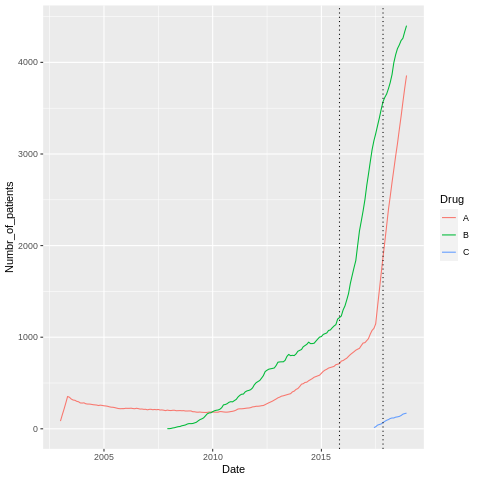

In [ ]:
# Plot the number of patients taking each drug (A,B,C) against time (March 2003- December 20118)
%%R
ggplot()+geom_line(aes(y=Numbr_of_patients, x=Date, color=Drug),size=.5, data=OATcn)+
  geom_vline(xintercept=as.numeric(OATcn$Date[c(155, 179)]), linetype="dotted") 

# Statistical Analysis:

# Oct 2015 Policy: Drug B (Naloxone)
Number of patients taking drug B increased by 1,120 patients/month (at the p=0.05 significance level)

In [ ]:
# Select data points for drug B only, for statistical analysis 
%%R
OATB<-OATcn %>% filter(Drug == "B") 

In [ ]:
# Create a categorical variable, with two labels: 'Before' vs after  'Naloxone'  policy
# Run the least square regression  
%%R
OATB$Policy<-ifelse(OATB$Date <'2015-10-01',"Before", "Naloxone")
summary(lm(Numbr_of_patients~Date+ factor(Policy), data=OATB))


Call:
lm(formula = Numbr_of_patients ~ Date + factor(Policy), data = OATB)

Residuals:
     Min       1Q   Median       3Q      Max 
-1303.80  -137.10   -27.08   179.96  1199.65 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -8.787e+03  8.993e+02  -9.771  < 2e-16 ***
Date                    6.082e-01  5.883e-02  10.338  < 2e-16 ***
factor(Policy)Naloxone  1.123e+03  1.510e+02   7.438 1.23e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 487.5 on 130 degrees of freedom
Multiple R-squared:  0.8522,	Adjusted R-squared:  0.8499 
F-statistic: 374.8 on 2 and 130 DF,  p-value: < 2.2e-16



#Jun 2017 Policy: Drug C (Slow-release Morphine)
Data confirms that the number of patients taking drug C commenced only after the policy was introduced

In [ ]:
# Select only drug C (Morphine) for further  analysis 
%%R
OATC<-OATcn %>% filter(Drug == "C") %>% group_by(Date)
head(OATC)

# A tibble: 6 × 2
  Date       Numbr_of_patients
  <date>                 <int>
1 2017-06-01                13
2 2017-07-01                22
3 2017-08-01                40
4 2017-09-01                47
5 2017-10-01                53
6 2017-11-01                69


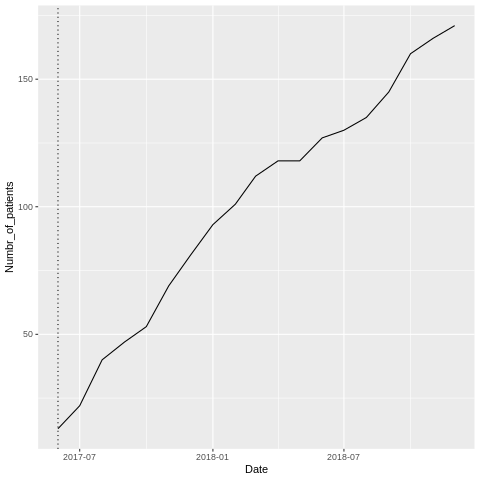

In [ ]:
# Vizualize patient uptake of drug C
%%R
ggplot()+geom_line(aes(y=Numbr_of_patients, x=Date),size=.5, data=OATC)+
  geom_vline(xintercept=as.numeric(OATC$Date[1]), linetype="dotted")

# The Control : Drug A (Methadone)

*   The control (Drug A), is where no policy was applied. After Oct 2015, number of patients taking the control showed lesser increase (260/month) compared to drug C (1,120/month). The control was not significant at the p=0.05 level.
*  The Oct 2015 policy was more effective than the control 
*   After Jun 2017, number of patients taking the control also increased. There may be an association between the Jun 2017 policy and the control (i.e., policy for drug C increased awareness of drug A)







In [ ]:
 # Select only Drug A for statistical analysis
%%R
OATA<-OATcn %>% filter(Drug == "A") 
head(OATA)

# A tibble: 6 × 3
# Groups:   Drug [1]
  Drug  Date       Numbr_of_patients
  <fct> <date>                 <int>
1 A     2003-01-01                84
2 A     2003-02-01               153
3 A     2003-03-01               212
4 A     2003-04-01               282
5 A     2003-05-01               353
6 A     2003-06-01               344


In [ ]:
# Divide the time-series into three: 
# 1 . before the policies: 2. after nalaxone but before morphine (this is the naloxone control); after morphine (morphine control)
%%R
OATA$Policy<-ifelse(OATA$Date <'2015-10-01',"Before", ifelse(OATA$Date > '2016-07-01', "Morphine_Control", "Naloxone_Conrol"))
summary(lm(Numbr_of_patients~Date+ factor(Policy), data=OATA))


Call:
lm(formula = Numbr_of_patients ~ Date + factor(Policy), data = OATA)

Residuals:
     Min       1Q   Median       3Q      Max 
-1061.07  -120.04   -17.31    97.66  1863.86 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -961.61426  347.87741  -2.764 0.006274 ** 
Date                              0.08694    0.02411   3.606 0.000398 ***
factor(Policy)Morphine_Control 1401.49487  110.15069  12.723  < 2e-16 ***
factor(Policy)Naloxone_Conrol   266.80733  144.29284   1.849 0.066018 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 402.3 on 188 degrees of freedom
Multiple R-squared:  0.6983,	Adjusted R-squared:  0.6935 
F-statistic: 145.1 on 3 and 188 DF,  p-value: < 2.2e-16



# Results and Learning

*   Following the October 2015 policy, the number of patients taking drug B, increased at a higher monthly rate and significance  level than the control drug A
*  It was only following the Jun 2017 policy, that patients commenced taking drug B. It appears that the policy was responsible for this increase. 
*   However, after Jun 2017 patients taking the control also started increasing, and significantly. It may be that the control is not entirely independent. For instance, the Oct 2017 policy may have enhanced patient awareness of the control
*   Success of policy outcomes requires analysis of the number of patients taking illicit drugs. This is data we may need from social service  agencies and, or law enforcement.

